In [31]:
import numpy as np
import pandas as pd

In [32]:
# fetch dataset from uci ml repository
from ucimlrepo import fetch_ucirepo
  
# fetch dataset 
airfoil_self_noise = fetch_ucirepo(id=291) 

# data (as pandas dataframes) 
X = airfoil_self_noise.data.features 
y = airfoil_self_noise.data.targets 
# metadata 
print(airfoil_self_noise.metadata) 
# variable information 
print(airfoil_self_noise.variables) 
print(X)

{'uci_id': 291, 'name': 'Airfoil Self-Noise', 'repository_url': 'https://archive.ics.uci.edu/dataset/291/airfoil+self+noise', 'data_url': 'https://archive.ics.uci.edu/static/public/291/data.csv', 'abstract': 'NASA data set, obtained from a series of aerodynamic and acoustic tests of two and three-dimensional airfoil blade sections conducted in an anechoic wind tunnel.', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1503, 'num_features': 5, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['scaled-sound-pressure'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C5VW2C', 'creators': ['Thomas Brooks', 'D. Pope', 'Michael Marcolini'], 'intro_paper': None, 'additional_info': {'summary': 'The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of

In [33]:
# define ploynomial fit method

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

def train_poly_ridge(X_train, y_train, degree=3, alpha=1.0):
    """Train Ridge regression with polynomial features."""
    model = Pipeline([
        ("scale", StandardScaler()),
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("ridge", Ridge(alpha=alpha, solver='auto')) # regularization
    ])
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """Evaluate model and print MSE."""
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")
    return y_pred


In [34]:
X.columns

Index(['frequency', 'attack-angle', 'chord-length', 'free-stream-velocity',
       'suction-side-displacement-thickness'],
      dtype='object')

In [35]:
# feature engineering: transform training data

def transform_features(X: pd.DataFrame) -> pd.DataFrame:
    # X_transformed = pd.DataFrame(index=X.index)
    X_transformed = X.copy()

    # frequency size related
    # X_transformed["frequency"] = X_transformed["log_frequency"]
    X_transformed["log_frequency"] = np.log1p(X["frequency"])
    X_transformed["log_thickness"] = np.log1p(X["suction-side-displacement-thickness"])

    # velocity related
    X_transformed["log_velocity_div_chord"] = np.log1p(X["free-stream-velocity"] / X["chord-length"])
    X_transformed["velocity_squared"] = X["free-stream-velocity"] ** 2

    # Basic transforms
    X_transformed["attack_angle_squared"] = X["attack-angle"] ** 2

    # Interaction terms
    X_transformed["freq_times_thick"] = X["frequency"] * X["suction-side-displacement-thickness"]
    X_transformed["velocity_div_chord"] = X["free-stream-velocity"] / X["chord-length"]
    X_transformed["angle_times_freq"] = X["attack-angle"] * X["frequency"]

    # Ratio of geometry
    X_transformed["thickness_to_chord"] = (
        X["suction-side-displacement-thickness"] / X["chord-length"]
    )
    
    return X_transformed


In [36]:
# train a model

# Split
X_train, X_test, y_train, y_test = train_test_split(
    airfoil_self_noise.data.features,
    airfoil_self_noise.data.targets,
    test_size=0.2,
    random_state=42
)

X_train_transformed = transform_features(X_train)
X_test_transformed = transform_features(X_test)
features = list(X_train_transformed.columns)

# Train model and evaluate
model = train_poly_ridge(X_train_transformed, y_train, degree=3, alpha=0.3)
y_pred = evaluate_model(model, X_test_transformed, y_test)

Mean Squared Error: 3.4968


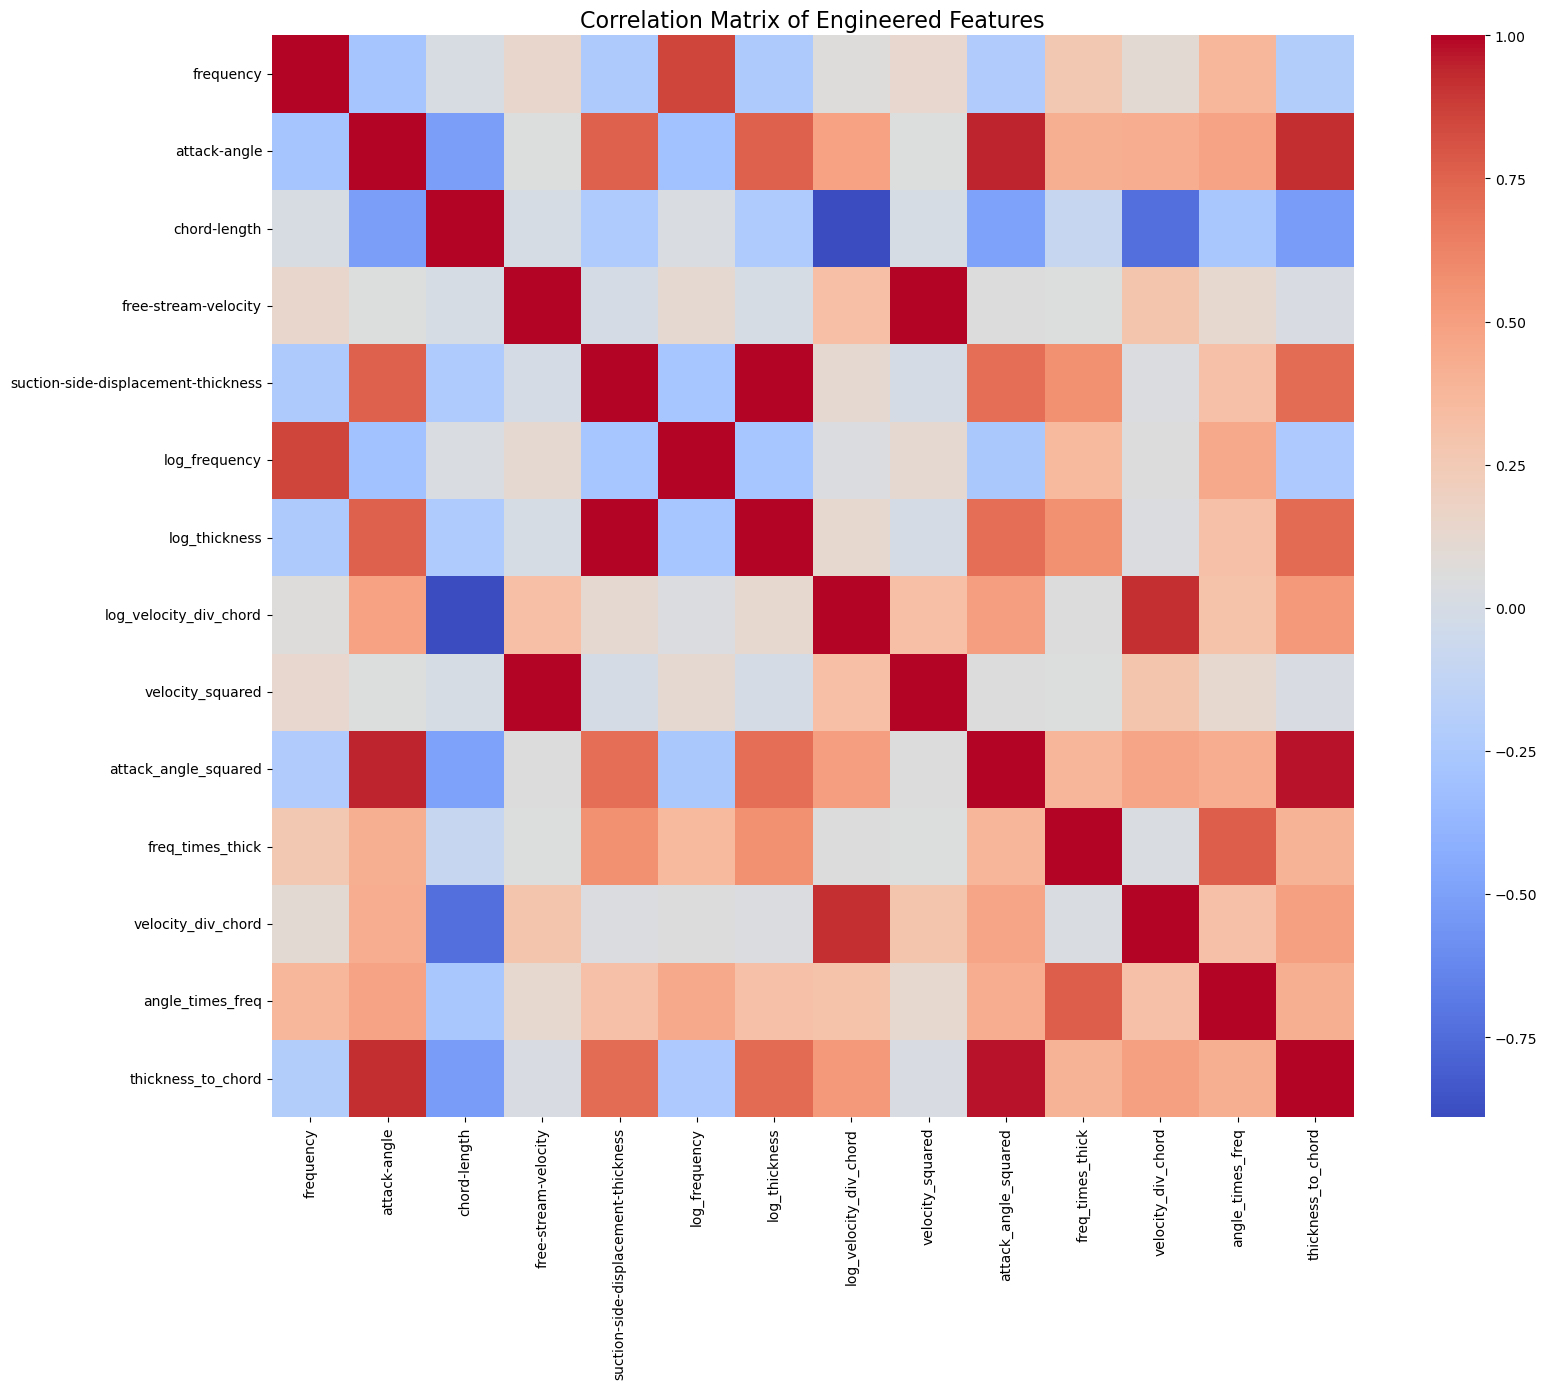

In [37]:
corr_matrix = X_train_transformed.corr()
import matplotlib.pyplot as plt
import seaborn as sns
# Plot heatmap

plt.figure(figsize=(18, 14))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, fmt=".2f", square=True, cbar=True)
plt.title("Correlation Matrix of Engineered Features", fontsize=16)
plt.tight_layout()
plt.show()

In [38]:
# compute corr coef

X_train_transformed["target"] = y_train
corr_matrix = X_train_transformed.corr()
target_corr = corr_matrix["target"].drop("target").sort_values(ascending=False)
print(target_corr)

log_velocity_div_chord                 0.265700
velocity_div_chord                     0.213807
free-stream-velocity                   0.120634
velocity_squared                       0.120266
attack_angle_squared                  -0.131568
attack-angle                          -0.131687
thickness_to_chord                    -0.135384
chord-length                          -0.241412
log_thickness                         -0.281684
suction-side-displacement-thickness   -0.282183
log_frequency                         -0.374685
frequency                             -0.409621
angle_times_freq                      -0.430317
freq_times_thick                      -0.572944
Name: target, dtype: float64


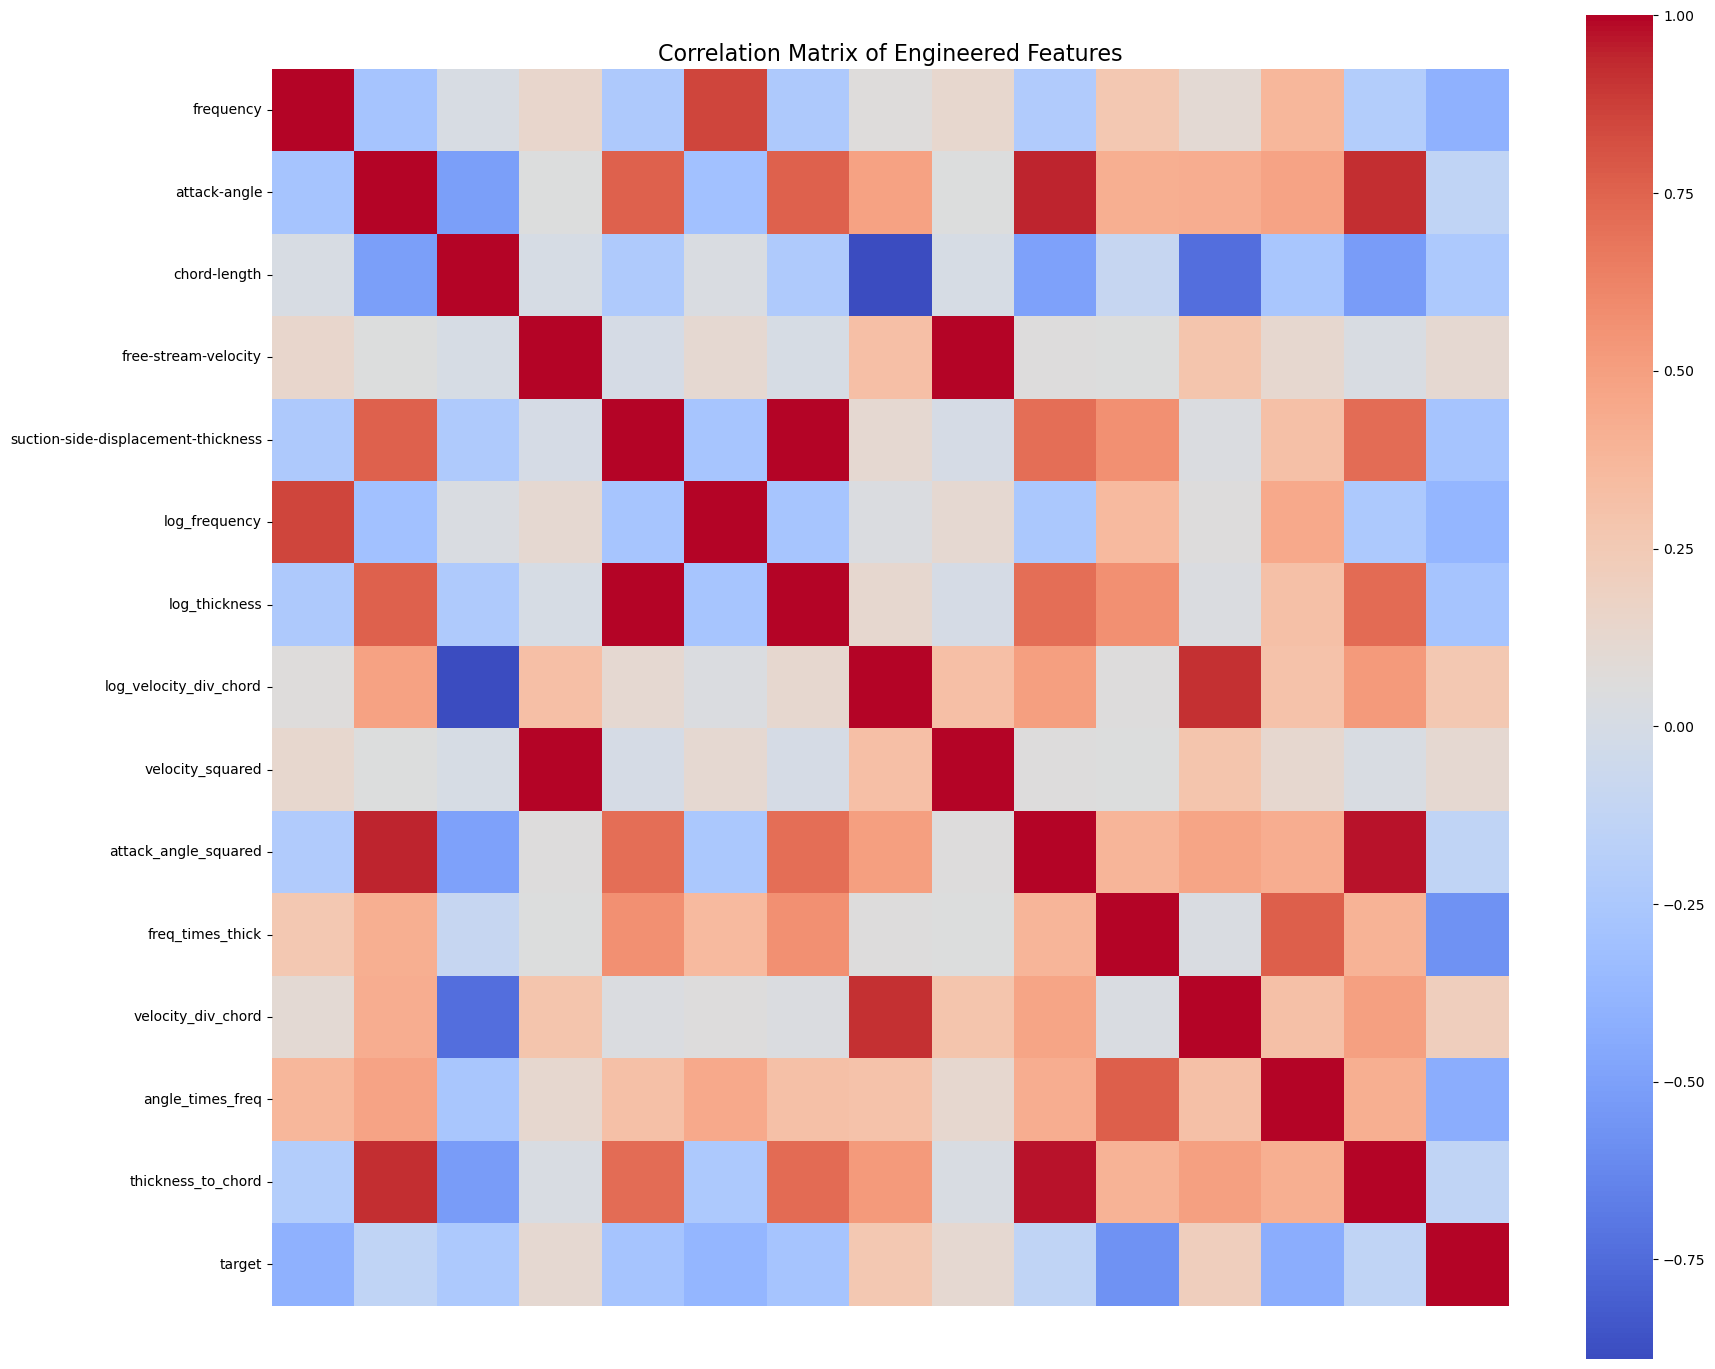

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 画相关性热图
plt.figure(figsize=(18, 14))
corr = X_train_transformed.corr()
sns.heatmap(corr, cmap="coolwarm", square=True, cbar=True, xticklabels=False, yticklabels=True)
plt.title("Correlation Matrix of Engineered Features", fontsize=16)
plt.tight_layout()
plt.show()


In [40]:
# find optimal param using grad search

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge

def build_pipeline():
    return Pipeline([
        ("scale", StandardScaler()),
        ("poly", PolynomialFeatures()),
        ("ridge", Ridge())
    ])

def run_grid_search(X_train, y_train):
    pipeline = build_pipeline()

    param_grid = {
        "poly__degree": [2, 3, 4, 5],
        "poly__interaction_only": [False],  # or [True, False]
        "ridge__alpha": [0.01, 0.1, 1, 10, 100],
        "ridge__solver": ['auto', 'saga', 'lsqr']
    }

    grid = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid


In [41]:
# # Gradient search

# grid = run_grid_search(X_train_transformed, y_train)

# # Best model and evaluation
# print("Best Parameters:", grid.best_params_)
# best_model = grid.best_estimator_
# y_pred = best_model.predict(X_test_transformed)

# # Evaluate
# mse = mean_squared_error(y_test, y_pred)
# print(f"Test MSE: {mse:.4f}")


In [42]:
# predict the testing data and output the submission file

X_sub_test = pd.read_csv("test.csv")
X_sub_test = X_sub_test.rename(columns={"displacement-thickness": "suction-side-displacement-thickness"})

X_transformed = transform_features(X)
X_sub_test_transformed = transform_features(X_sub_test)

# use the full train and cross validation data to train a new model
model = train_poly_ridge(X_transformed, y, degree=3, alpha=0.3)
y_pred = model.predict(X_sub_test_transformed[features])

df_pred = pd.DataFrame({'scaled-sound-pressure': y_pred.ravel()})
df_pred.index.name = 'id'
df_pred.to_csv('submission.csv', index=True)

In [43]:
# overview the train, test, and predict dataset

training_df = pd.read_csv("train.csv")
print(training_df.describe())
# print(X_sub_test.describe())
# print(df_pred.describe())

          frequency  attack-angle  chord-length  free-stream-velocity  \
count    901.000000    901.000000    901.000000            901.000000   
mean    2795.620739      6.892802      0.137146             51.202533   
std     3105.639153      5.832397      0.093021             15.699815   
min      135.711714     -0.169984      0.022660             31.206276   
25%      657.858026      2.015625      0.050679             39.473120   
50%     1601.756769      5.405799      0.103025             39.972518   
75%     4002.479032      9.982948      0.227843             71.189522   
max    20066.902526     22.295612      0.307748             71.755857   

       displacement-thickness  scaled-sound-pressure  
count              901.000000             901.000000  
mean                 0.011361             124.908380  
std                  0.013238               6.904827  
min                  0.000119             103.324708  
25%                  0.002690             120.491306  
50%         